Start with modeling:
Try neural nets and other machine learning algorithms

Input data:
We want to predict future volatility -> i.e. predict the VOLQ  
 - Past volatility, i.e. past values of the VOLQ 
 - Historical returns, i.e. log diff of the NASDAQ stock price (closing price?)
 - Add sentiment later -> start without 
 - Maybe volume of stock
 - US GDP growth
 - Consumer confidence index
 - US inflation 
 - US interest rates

1. step: download needed data, 2015-2020, merge datasets into one good pandas dataframe
2. Start with modeling, try recursive neural network? maybe first try basic ones like random forest, gradient boosting etc. 
3. Evaluate models using MSE
4. Forecasting: expanding window forecasting
5. Build classifier: 
    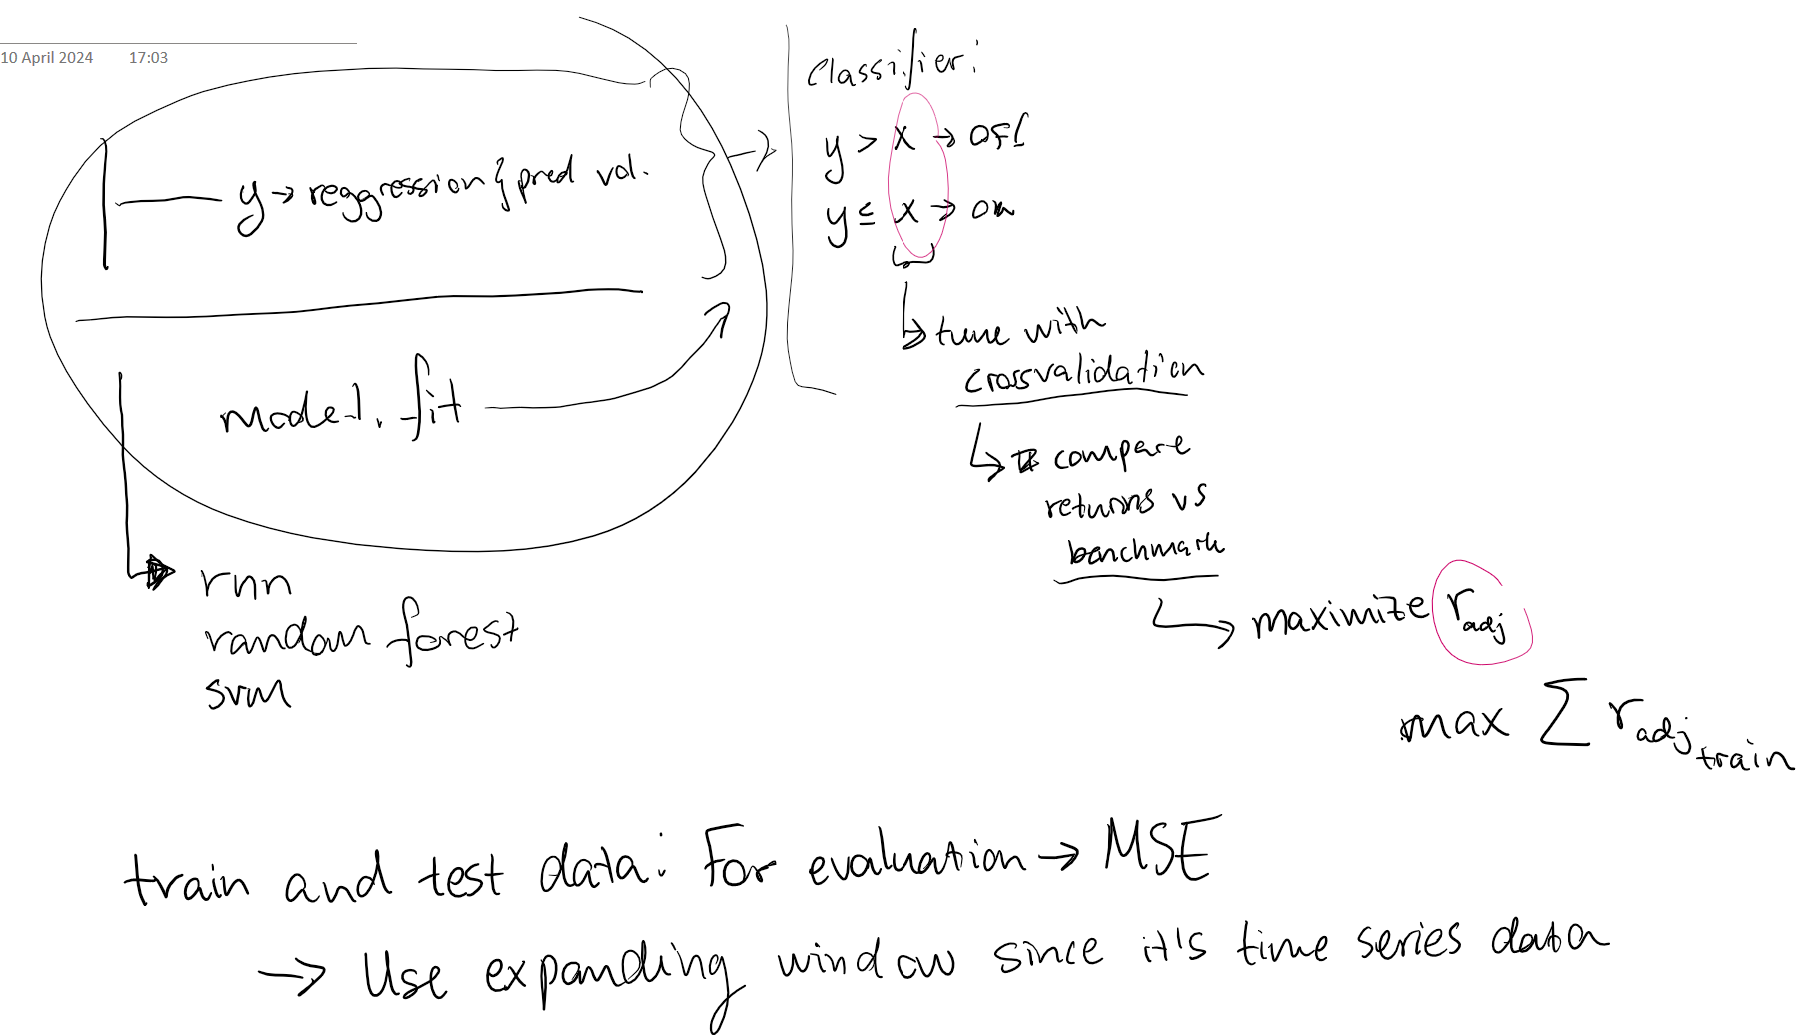
6. well see

In [39]:
#Necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### First step: Data

#### Checklist: Loading data:
 - [X] VOLQ
 - [X] Price
 - [X] Volume
 - [] US GDP growth -> only quarterly data so idk if its useful
 rest is monthly data, but we can just make it daily by having each day of the month have the same value
 - [X] Interest rates 
 - [X] Inflation
 - [X] Consumer confidence index

In [64]:
#Get volatility historical data:

url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])


In [81]:
volatility_df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1253,2015-01-08,16.61,16.61,16.61,16.61,NaN,-3.43%
1254,2015-01-07,17.20,17.20,17.20,17.20,NaN,-9.71%
1255,2015-01-06,19.05,19.05,19.05,19.05,NaN,5.83%
1256,2015-01-05,18.00,18.00,18.00,18.00,NaN,8.50%
1257,2015-01-02,16.59,16.59,16.59,16.59,NaN,4.27%


In [67]:
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/Nasdaq100_price_data.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,4294.879883,4307.009766,4233.709961,4236.279785,4236.279785,1515600000
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000


In [68]:
price_df['Log_Returns'] = np.log(price_df['Close']).diff()*100

#drop 2014-12-31 from the data:
price_df = price_df[price_df['Date'] > '2014-12-31']
price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Returns
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000,-0.142669
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000,-1.651298
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000,-1.212083
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000,1.189010
5,2015-01-08,4195.490234,4247.930176,4192.629883,4240.549805,4240.549805,2105450000,1.917786


In [82]:
# CPI data:
url_cpi = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/us_cpi_dec2014to2019.csv'
cpi_df = pd.read_csv(url_cpi)

# add monthly inflation rates (log difference like the returns)
# - not sure if log-diff is the best approach for inflation but maybe makes sense for consistency at least?

cpi_df['Log_inflation'] = np.log(cpi_df['CPIAUCSL']).diff()*100

cpi_df.head()

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])

# Filter out the first month (December 2014)
df_filtered = cpi_df[cpi_df['DATE'] > '2014-12-01']

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in df_filtered.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'CPIAUCSL': row['CPIAUCSL'],
        'Log_inflation': row['Log_inflation']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cpi_daily_data = daily_data
cpi_daily_data.head()

,DATE,CPIAUCSL,Log_inflation
0,2015-01-01,234.747,-0.639069
1,2015-01-02,234.747,-0.639069
2,2015-01-03,234.747,-0.639069
3,2015-01-04,234.747,-0.639069
4,2015-01-05,234.747,-0.639069


In [83]:
# interest rates data

url_ir = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US_interest_rates_historical.csv'
ir_df = pd.read_csv(url_ir)

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

#make the date a datetime object:
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in ir_df.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'interest_rate': row['INTDSRUSM193N']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)
ir_daily_data = daily_data
ir_daily_data.head()

,DATE,interest_rate
0,2015-01-01,0.75
1,2015-01-02,0.75
2,2015-01-03,0.75
3,2015-01-04,0.75
4,2015-01-05,0.75


In [84]:
#get consumer confidence data:
cci_url = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/consumer_barometer_US2015to2019.csv'

cci_df = pd.read_csv(cci_url)

cci_df = pd.DataFrame({'Date': cci_df['TIME_PERIOD'],
                      'consumer_barometer': cci_df['OBS_VALUE']})

cci_df['Date'] = pd.to_datetime(cci_df['Date'])

#make it daily:

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in cci_df.iterrows():
    # Get the first and last day of the month
    start_date = row['Date']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'Date': date_range,
        'consumer_barometer': row['consumer_barometer']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cci_daily_data = daily_data
cci_daily_data.head()

,Date,consumer_barometer
0,2015-01-01,0.353886
1,2015-01-02,0.353886
2,2015-01-03,0.353886
3,2015-01-04,0.353886
4,2015-01-05,0.353886


In [86]:
# merge the datasets and keep only the columns of interest:

# Assuming volatility_df, price_df, cpi_daily_data, ir_daily_data, cci_daily_data are already defined

# Step 1: Standardize Date Column Names
cpi_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)
ir_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)

# Step 2: Merge DataFrames
# Merge volatility_df and price_df
merged_df = pd.merge(volatility_df[['Date', 'Price']], 
                     price_df[['Date', 'Log_Returns', 'Volume']], 
                     on='Date', 
                     how='inner')

# Merge with cpi_daily_data
merged_df = pd.merge(merged_df, 
                     cpi_daily_data[['Date', 'Log_inflation']], 
                     on='Date', 
                     how='inner')

# Merge with ir_daily_data
merged_df = pd.merge(merged_df, 
                     ir_daily_data[['Date', 'interest_rate']], 
                     on='Date', 
                     how='inner')

# Merge with cci_daily_data
merged_df = pd.merge(merged_df, 
                     cci_daily_data[['Date', 'consumer_barometer']], 
                     on='Date', 
                     how='inner')

# merged_df now contains all the desired columns with matching dates


In [87]:
#rename 'Price' to 'Volatility' and more relevant column names:
merged_df.rename(columns={'Price' : 'Volatility', 'Log_Returns' : 'stock_log_returns', 'Volume':'stock_volume', 'Log_inflation':'US_log_inflation', 'interest_rate':'US_interest_rate'}, inplace = True)
merged_df.head()


,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
0,2019-12-30,15.36,-0.700775,2051320000,0.290799,2.25,0.196109
1,2019-12-27,14.03,-0.083526,1833740000,0.290799,2.25,0.196109
2,2019-12-26,12.58,0.901718,1639960000,0.290799,2.25,0.196109
3,2019-12-24,12.36,0.040240,1014530000,0.290799,2.25,0.196109
4,2019-12-23,12.34,0.201670,2028670000,0.290799,2.25,0.196109


In [88]:
merged_df['Date'].min()

Timestamp('2015-01-02 00:00:00')

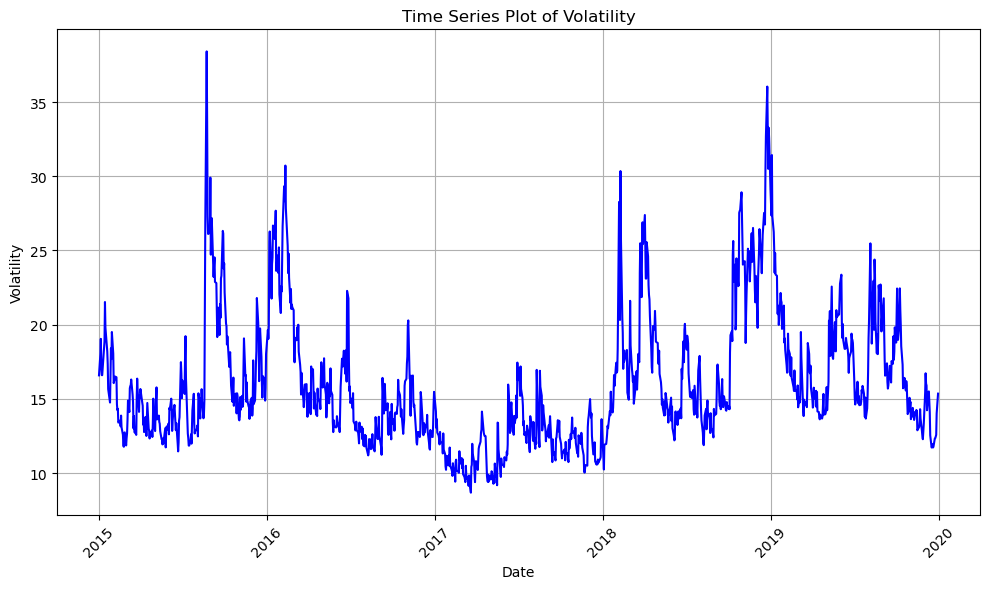

In [90]:
# Plotting the Volatility over time
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(merged_df['Date'], merged_df['Volatility'], linestyle='-', color='blue')  # Plotting data
plt.title('Time Series Plot of Volatility')  # Adding a title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Volatility')  # Y-axis label
plt.grid(True)  # Adding a grid for better readability
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability
plt.tight_layout()  # Adjusting the layout to make room for the rotated x-axis labels

# Displaying the plot
plt.show()